In [42]:
import os
import re
import networkx as nx
import codecs
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline
from collections import defaultdict
from IPython.display import Image

## Словари

In [30]:
def read_dix(dir):
    filename = dir.split(".")[1]
    l,r = filename.split("-")
    print("Reading " + filename + "...")
    result = []
    with codecs.open(dir, 'r') as dix:
        for line in dix:
            if not 'r="LR"' in line and not 'r="RL"' in line:
                left = re.findall("<p>\s*<l>(.+?)<s", line)
                right = re.findall("</l>\s*<r>(.+?)<s", line)
                pos = re.findall("<s n=\"(.+?)\"/>", line)
                if left and right and pos:
                    result.append((left[0].replace("<b/>", " ") + "_" + l, right[0].replace("<b/>", " ") + "_" + r, pos[0]))
    return result

Вот какие словари у меня есть:

In [21]:
path = "/Users/ulyanasidorova/Desktop/lang"
translations = {"spa": "Spanish", "ita": "Italian", "cat": "Catalan", "fra": "French",
                "scn": "Sicilian", "por": "Portuguese", "srd": "Sardinian"}
dix_names = []
for filename in os.listdir(path):
    if filename.endswith("dix"):
        name = filename.split(".")[1]
        dix_names.append(name)
        name = name.split("-")
        print translations[name[0]], "<--->", translations[name[1]]

Catalan <---> Italian
Catalan <---> Sardinian
French <---> Catalan
French <---> Portuguese
French <---> Spanish
Portuguese <---> Catalan
Sicilian <---> Spanish
Spanish <---> Catalan
Spanish <---> Italian
Spanish <---> Portuguese
Sardinian <---> Italian


Можно визуализировать связи между словарями:

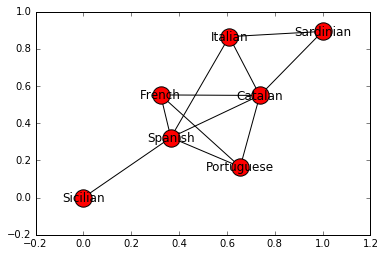

In [18]:
dix = dict.fromkeys(dix_names, [])

lang = []
for name in dix_names:
    name = name.split("-")
    lang.append((translations[name[0]], translations[name[1]]))
languages = nx.Graph()
languages.add_edges_from(lang)
nx.draw_networkx(languages, with_labels=True, font_size=12)

Сразу можно увидеть клику между испанским, французским, португальским и каталанским языком – я их условно называю "большая четвёрка", так как среди романских языков для них больше всего ресурсов (по крайней мере, у организации Apertium). Для всех этих языков есть словари, связывающие их с другими членами клики. Каждый из этих языков может служить своеобразным pivot – языком-посредником для перевода между двумя языками, для которых нет прямого перевода (например, между сицилийским и французским или португальским и итальянским).

А вот и максимальная клика в этом маленьком графе:

In [67]:
cliques = list(nx.find_cliques(languages))
print max(cliques, key=len)

['Catalan', 'Spanish', 'Portuguese', 'French']


## Мультиязычный мега-граф

Загрузим имеющиеся словари.

In [68]:
for filename in os.listdir(path):
    if filename.endswith("dix"):
        name = filename.split(".")[1]
        dix[name] = read_dix(path + "/" + filename)
print "Done."

Reading cat-ita...
Reading cat-srd...
Reading fra-cat...
Reading fra-por...
Reading fra-spa...
Reading por-cat...
Reading scn-spa...
Reading spa-cat...
Reading spa-ita...
Reading spa-por...
Reading srd-ita...
Done.


Теперь создадим один мультиязычный граф (в него я пока что включаю только существительные).

In [33]:
G = nx.Graph()
all_edges = []
for key in dix:
    for word_pair in dix[key]:
        if word_pair[2] == "n":
            all_edges.append((word_pair[0], word_pair[1]))

G.add_edges_from(all_edges)
print(nx.info(G))
for node in list(G.nodes(data=True)):
    node[1]['lang'] = node[0].split("_")[1]

Name: 
Type: Graph
Number of nodes: 65789
Number of edges: 56608
Average degree:   1.7209


Граф просто огромный – 65 тысяч узлов (и это только существительные!). Визуализировать и анализировать его сложно, поэтому учтём, что граф состоит из великого множества небольших соединённых компонентов. Этих компонентов намного меньше, чем просто слов в словаре, в итоге получаем более компактное и логичное представление.

In [69]:
subgraphs = list(nx.connected_components(G))
subgraphs.sort(key=len, reverse=True)
print len(subgraphs)

19401


Как выглядят эти подграфы мультиязычного графа?

*Так как у меня проблемы с юникодом во втором питоне на jupyter notebook, я просто вставлю графы картинкой. Рисовала я на третьем питоне, где с юникодом всё проще...*

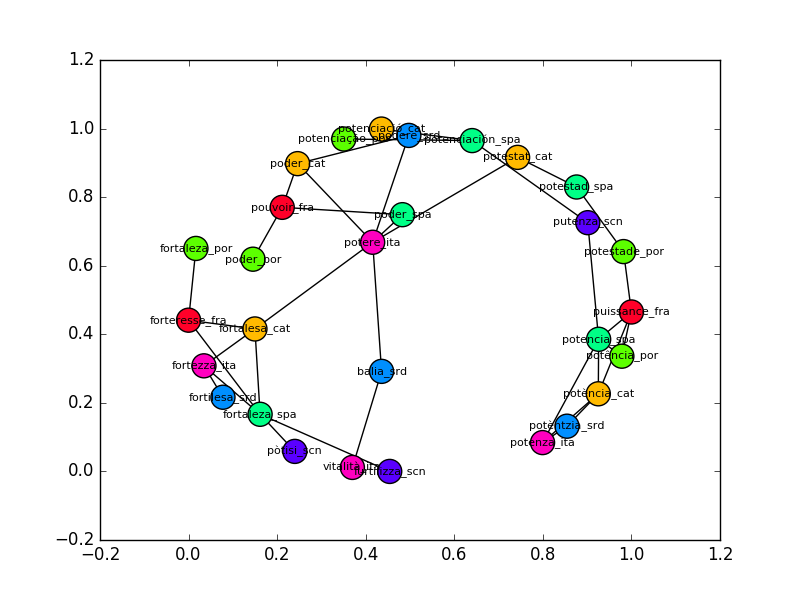

In [71]:
Image('/Users/ulyanasidorova/Desktop/figure_2.png')

**Небольшой комментарий к графику.**

Я добавила к словам нижнее подчёркивание с указанием языка, так как иначе невозможно будет создать отдельные вершины для слов, одинаковых в нескольких языках (например, слово "poder", которое есть в испанском, португальском и каталанском).

У каждого языка свой цвет. Граф, кстати, получается многодольный (k-partite), только я не совсем знаю, как это можно проверить и что из этого можно получить.

Само понятие, изображённое на данном графе, достаточно объёмное и включает много синонимво: оно означает силу, власть, а также способность и особое право на что-либо. Однако не все мульти-слова такие многозначные. Вот примеры других слов:

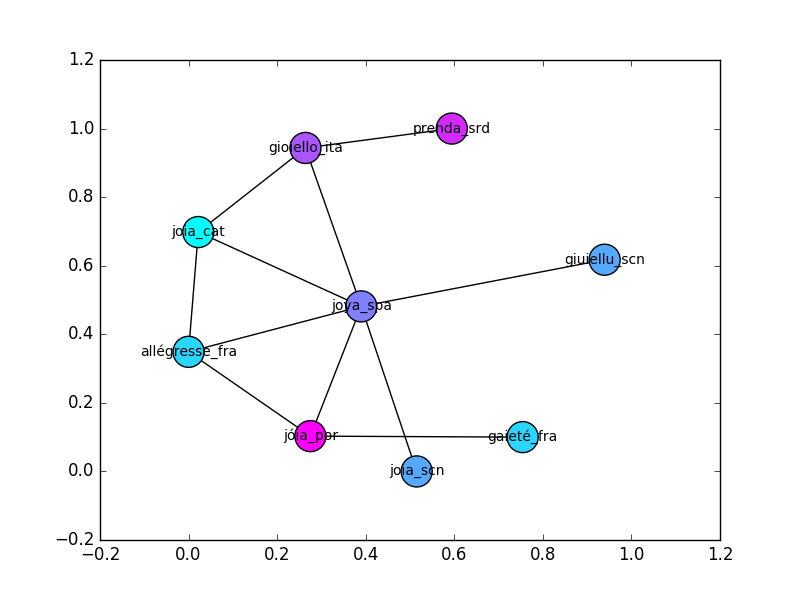

In [72]:
Image('/Users/ulyanasidorova/Desktop/figure_3.png')

Это **"радость"** в разных языках.

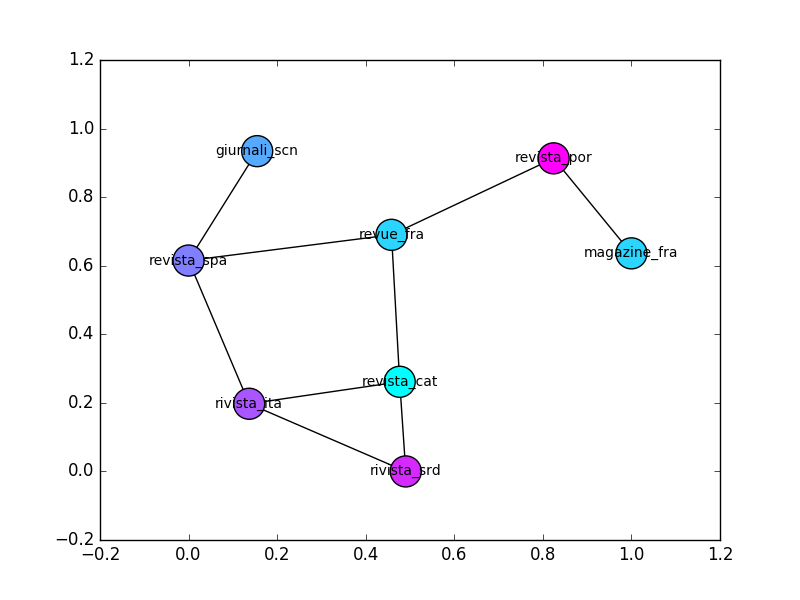

In [74]:
Image('/Users/ulyanasidorova/Desktop/figure_4.png')

А это – **"журнал"**.

## Мини-граф: структура

Если мы посмотрим на граф понятия "сила, власть", то сложно что-то увидеть в его структуре так сразу:

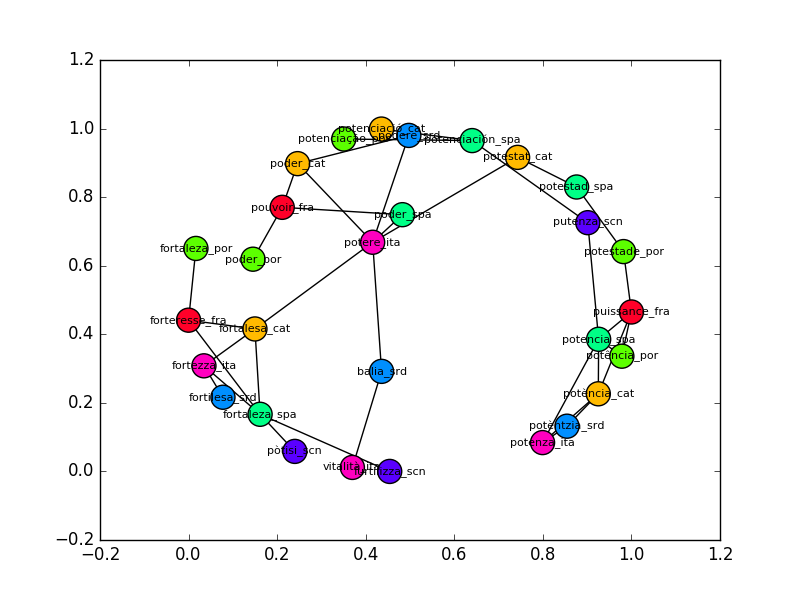

In [78]:
Image('/Users/ulyanasidorova/Desktop/figure_2.png')

Нарисуем только те узлы, которые принадлежат к языкам *pivot* – языкам большой четвёрки.

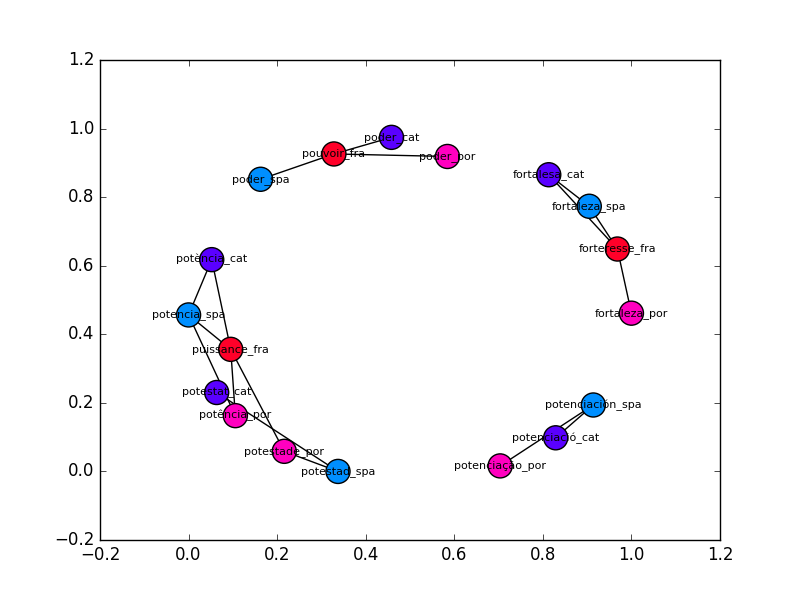

In [79]:
Image('/Users/ulyanasidorova/Desktop/figure_7.png')

Сразу стало отлично видно, что появились 4 кластера. И они не какие-то абстрактные. Группы образовались по наиболее схожим словам!

- Poder, poder, poder, pouvoir...

- Fortaleza, fortalesa, forteresse, fortaleza...

- Potenciacion, potenciacio, potenciacao...

- Potencia, potestade, potestad, potestat...

А ещё отдельно посмотрим на самый крупный кластер в левом нижнем углу.

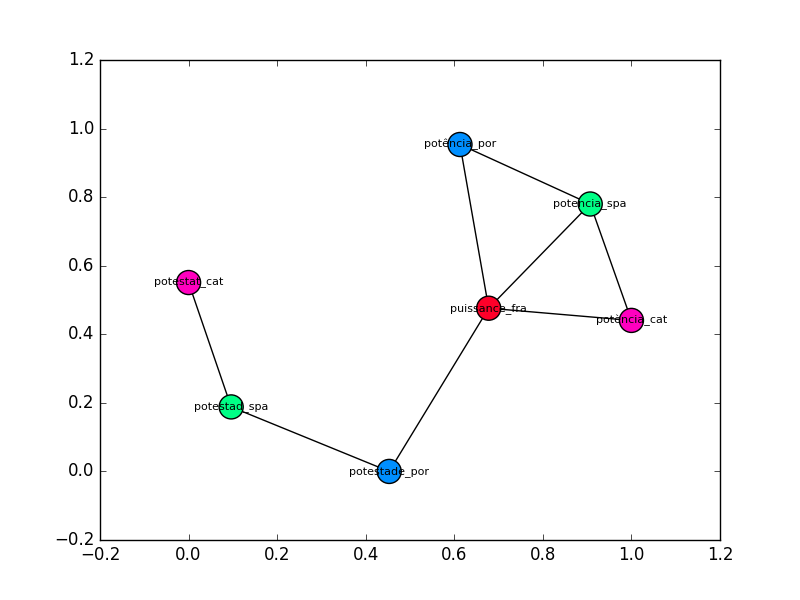

In [61]:
Image('/Users/ulyanasidorova/Desktop/figure_8.png')

И вот что можно увидеть. В центре находится французское слово *puissance*. Это слово мостиком соединяет две группы, в которых узлы крайне похожи друг на друга! Одна группа включает в себя *potestat, potestad* и *potestade*, а вторая – *potencia, potencia* и *potencia*. И языки в этих группах одинаковые (можно посмотреть по цветам). То есть фактически, французское слово *puissance* двузначное и переводится двумя словами на португальский, испанский и каталонский. Как следствие, этот кластер тоже можно разбить на два.

### Теперь возникает вопрос, зачем всё это нужно...


Моя идея (и идея Фрэнсиса, моего куратора в Апертиуме) состоит в том, что это знание о структуре связанных компонентов графа может помочь выводить двусторонние словари для языков, между которыми нет сооветствий, а также восполнять пробелы в уже имеющихся языках.

#### Например...

На последней картинке мы можем перекинуть связи между всеми узлами в каждой группе и получить такую картику:

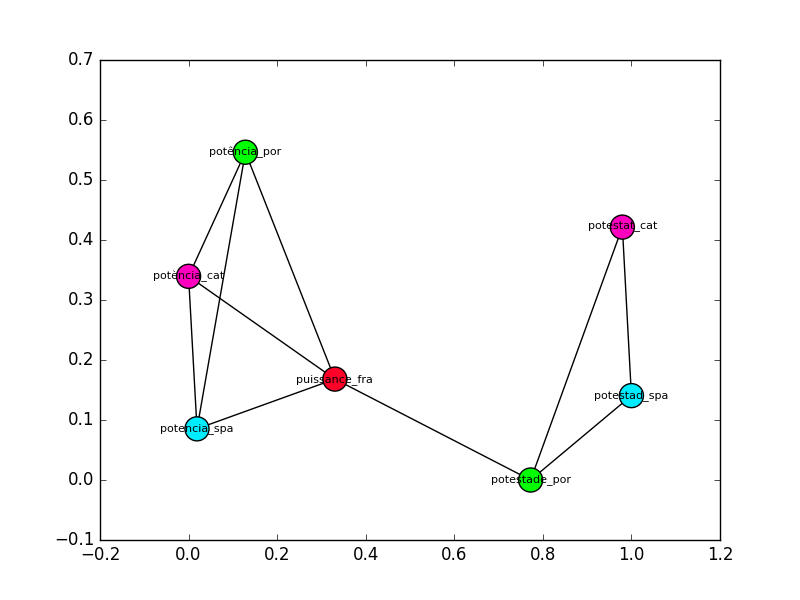

In [80]:
Image('/Users/ulyanasidorova/Desktop/figure_9.png')

А если так сделать для всех кластеров во всех связанных компонентах мультиязычного графа – какой прирост получают даже самые разработанные словари (ведь мы пока рассматриваем языки из максимальной клики)!


Теперь вернёмся к полной картинке, изображающей понятие "сила, власть". Ещё раз, вот она:

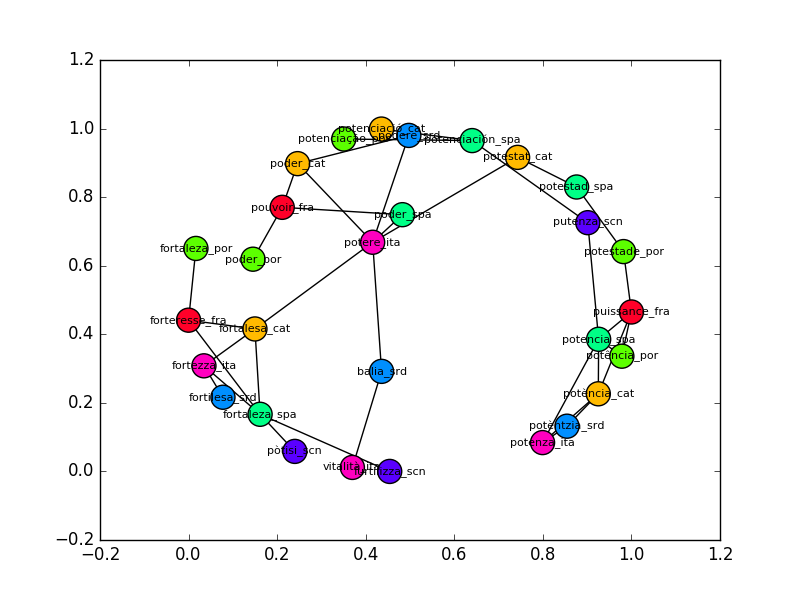

In [81]:
Image('/Users/ulyanasidorova/Desktop/figure_2.png')

Мы уже выяснили, что есть пять сновных кластеров для четырёх крупных языков. Посмотрим теперь, как присоединяются к этим кластерам слова из менее распространённых языков (сицилийских, сардинский). Для этого нарисуем все слова из языков "большой четвёрки" одним цветом, а слова из маленьких языков – другим.

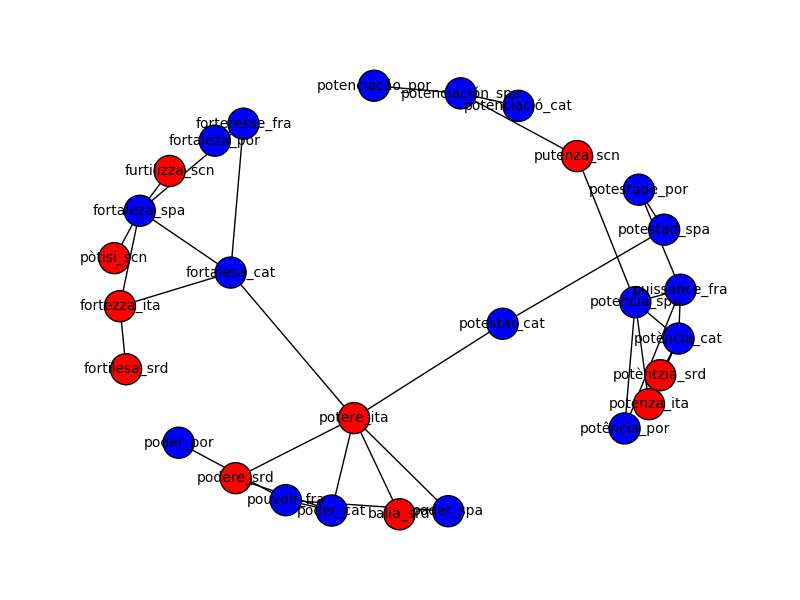

In [82]:
Image('/Users/ulyanasidorova/Desktop/figure_10.png')

Здесь видно, что похожие слова относятся к похожим кластерам. Например, итальянское "fortezza" в том же кластере, что и слова "fortaleza" и "fortalesa". А сицилийское "putenza" – ближе к той же группе, что и каталонское и португальское "potencia". Даже не-лингвист почувствует сходство...

Получается, что если мы сначала дополним все связи в языках "большой четвёрки", а затем добавим слова из малых языков, то мы с очень большой вероятностью сделаем правильные переводы без слишком широких обобщений (т.е. не будем переводить два неблизких слова – putenza и fortalezza). И насколько это быстрее, чем переводить вручную (а словари Apertium создаются именно ручной разметкой).

## Мотивация

Почему я хочу это сделать. Я уже почти год работаю вместе с организацией Apertium и помогаю собирать материалы для языков с небольшой демографической поддержкой (диалекты, варианты и просто небольшие региональные языки). Обычно прямые словари для двух языков составляются носителями, но носителей мало, особенно знакомых с Апертиумом, поэтому приходится пользоваться дополнительными средствами для расширения возможностей машинного перевода.